# Data:

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt
from torchvision import transforms

import h5py
import numpy as np
import os

In [2]:
with h5py.File('galaxies_project3.h5', 'r') as f_read:
    print("Keys in the HDF5 file:", list(f_read.keys()))

    dataset_data = f_read['images'][()]
    labels = f_read['ans'][()]

Keys in the HDF5 file: ['ans', 'images']


Shape de labels: (21785,)


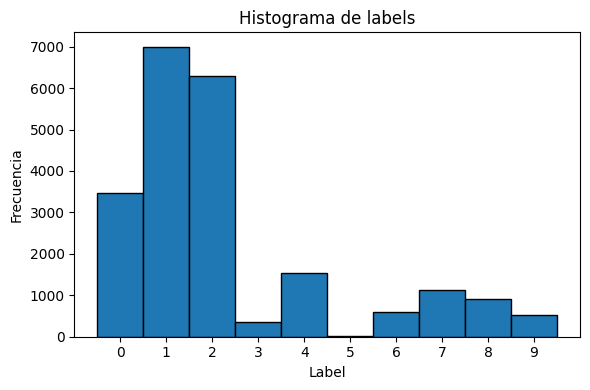

In [3]:
# Cargar labels desde el archivo (ajusta el nombre si es distinto)
with h5py.File('galaxies_project3.h5', 'r') as f:
    labels = f['ans'][()]   # <- aquí está tu vector de labels

print("Shape de labels:", labels.shape)

# Opción 1: Histograma directo (si los labels son enteros)
plt.figure(figsize=(6,4))
plt.hist(labels, bins=np.arange(labels.min(), labels.max() + 2) - 0.5, edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Frecuencia')
plt.title('Histograma de labels')
plt.xticks(np.arange(labels.min(), labels.max() + 1))
plt.tight_layout()
plt.show()


AQUI!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Dataset original: (21785, 69, 69, 3)
Procesadas 8000/21785 imágenes (actual total: 28614)
Procesadas 15000/21785 imágenes (actual total: 53335)
Procesadas 16000/21785 imágenes (actual total: 56865)
Procesadas 18000/21785 imágenes (actual total: 63661)
Procesadas 21000/21785 imágenes (actual total: 74207)
Total de imágenes en el archivo rotado: 76983


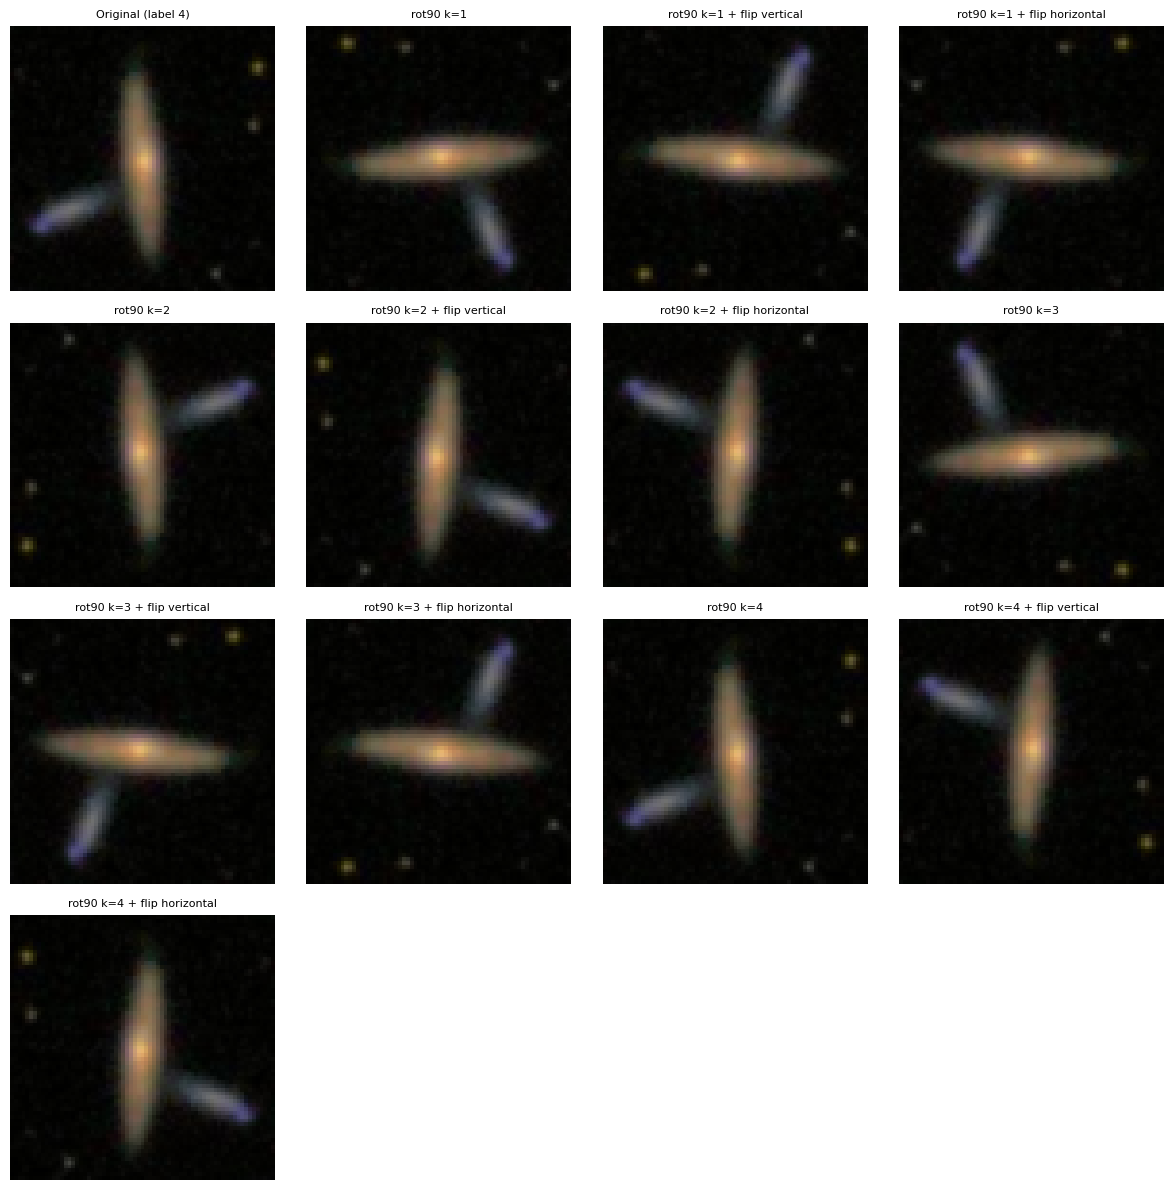

In [5]:
# -------------------------------------------------------------
# CELDA 1: Rotaciones + flips y guardado en HDF5 (streaming)
#          + plot de ejemplo de todas las transformaciones
# -------------------------------------------------------------
import h5py
import numpy as np
import matplotlib.pyplot as plt

archivo_entrada = 'galaxies_project3.h5'
archivo_salida_rot = 'galaxies_project3_rot.h5'

# labels que queremos augmentar
labels_a_augmentar = {3, 4, 6, 7, 8, 9}

with h5py.File(archivo_entrada, 'r') as f_in, \
     h5py.File(archivo_salida_rot, 'w') as f_out:
    
    data_in = f_in['images']   # (N, H, W, C)
    labels_in = f_in['ans']  # (N,)
    
    N, H, W, C = data_in.shape
    print("Dataset original:", data_in.shape)
    
    # Creamos datasets redimensionables
    dset_imgs = f_out.create_dataset(
        'images',
        shape=(0, H, W, C),
        maxshape=(None, H, W, C),
        dtype=data_in.dtype,
        compression='gzip',
        chunks=(1, H, W, C)
    )
    dset_labels = f_out.create_dataset(
        'ans',
        shape=(0,),
        maxshape=(None,),
        dtype=labels_in.dtype,
        compression='gzip',
        chunks=(1024,)
    )
    
    current_n = 0
    
    # Guardaremos SOLO una imagen de ejemplo para mostrar todas las rotaciones y flips
    img_ejemplo = None
    lab_ejemplo = None
    
    for i in range(N):
        img = data_in[i]      # (H, W, C)
        lab = labels_in[i]    # escalar
        
        # 1) Guardar siempre la imagen original
        dset_imgs.resize(current_n + 1, axis=0)
        dset_labels.resize(current_n + 1, axis=0)
        dset_imgs[current_n] = img
        dset_labels[current_n] = lab
        current_n += 1
        
        # Elegimos una imagen de ejemplo de alguna clase a augmentar
        if (img_ejemplo is None) and (lab in labels_a_augmentar):
            img_ejemplo = img[...].copy()
            lab_ejemplo = int(lab)
        
        # 2) Si el label no está en los que augmentamos, seguimos
        if lab not in labels_a_augmentar:
            continue
        
        # 3) Generar rotaciones y flips para este label (streaming)
        for k in [1, 2, 3, 4]:
            rot = np.rot90(img, k=k)   # rota en plano (H, W)
            
            # Evitar duplicar la original: 4*90° = 360° (misma imagen)
            if k != 4:
                dset_imgs.resize(current_n + 1, axis=0)
                dset_labels.resize(current_n + 1, axis=0)
                dset_imgs[current_n] = rot
                dset_labels[current_n] = lab
                current_n += 1
            
            # Flip vertical (up-down)
            rot_flip_v = np.flipud(rot)
            dset_imgs.resize(current_n + 1, axis=0)
            dset_labels.resize(current_n + 1, axis=0)
            dset_imgs[current_n] = rot_flip_v
            dset_labels[current_n] = lab
            current_n += 1
            
            # Flip horizontal (left-right)
            rot_flip_h = np.fliplr(rot)
            dset_imgs.resize(current_n + 1, axis=0)
            dset_labels.resize(current_n + 1, axis=0)
            dset_imgs[current_n] = rot_flip_h
            dset_labels[current_n] = lab
            current_n += 1
        
        if (i + 1) % 1000 == 0:
            print(f"Procesadas {i+1}/{N} imágenes (actual total: {current_n})")
    
    print("Total de imágenes en el archivo rotado:", current_n)

# -------------------------------------------------------------
# Plot de ejemplo: original + rotaciones + flips para una sola imagen
# -------------------------------------------------------------
if img_ejemplo is not None:
    # Generamos todas las variantes SOLO para visualizar
    variantes = []
    titulos = []
    
    variantes.append(img_ejemplo)
    titulos.append(f"Original (label {lab_ejemplo})")
    
    for k in [1, 2, 3, 4]:
        rot = np.rot90(img_ejemplo, k=k)
        variantes.append(rot)
        titulos.append(f"rot90 k={k}")
        
        variantes.append(np.flipud(rot))
        titulos.append(f"rot90 k={k} + flip vertical")
        
        variantes.append(np.fliplr(rot))
        titulos.append(f"rot90 k={k} + flip horizontal")
    
    n_var = len(variantes)
    n_cols = 4
    n_rows = int(np.ceil(n_var / n_cols))
    
    plt.figure(figsize=(3*n_cols, 3*n_rows))
    for i, (img_v, title) in enumerate(zip(variantes, titulos)):
        ax = plt.subplot(n_rows, n_cols, i+1)
        if img_v.ndim == 2:
            ax.imshow(img_v, cmap='gray')
        else:
            ax.imshow(img_v)
        ax.set_title(title, fontsize=8)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No se encontró ninguna imagen de ejemplo con labels_a_augmentar.")


Dataset rotado: (76983, 69, 69, 3)
Índices de la muestra: [20768 23697 39347 49033 65480]
Labels de la muestra: [9 2 0 9 8]


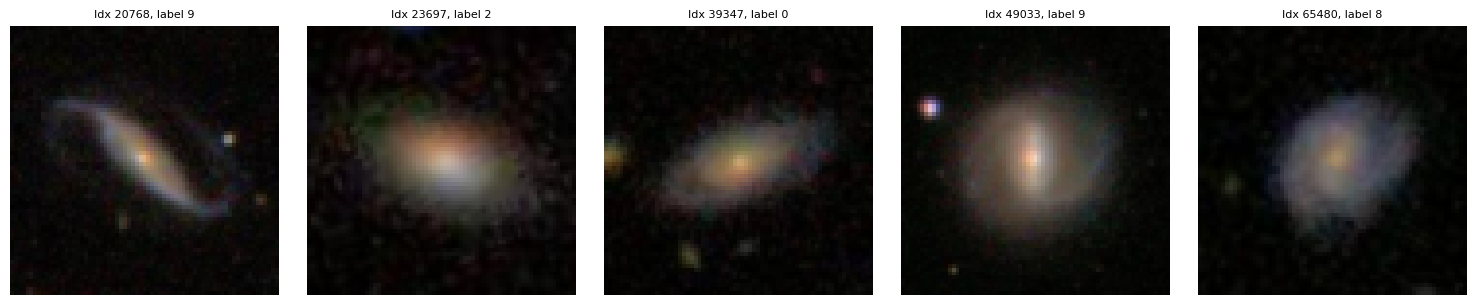

In [6]:
# -------------------------------------------------------------
# CELDA 2: Muestreo de imágenes ANTES del blanqueo
# -------------------------------------------------------------
import h5py
import numpy as np
import matplotlib.pyplot as plt

archivo_salida_rot = 'galaxies_project3_rot.h5'

num_mostrar = 5  # cuántas imágenes queremos visualizar

with h5py.File(archivo_salida_rot, 'r') as f:
    imgs = f['images']
    labs = f['ans']
    
    N = imgs.shape[0]
    print("Dataset rotado:", imgs.shape)
    
    # Elegimos índices aleatorios reproducibles
    rng = np.random.default_rng(seed=0)
    indices_muestra = rng.choice(N, size=min(num_mostrar, N), replace=False)
    indices_muestra = np.sort(indices_muestra)
    
    print("Índices de la muestra:", indices_muestra)
    print("Labels de la muestra:", labs[indices_muestra])
    
    muestra_antes = [imgs[i][...] for i in indices_muestra]
    labels_muestra = [int(labs[i]) for i in indices_muestra]

# Plot de la muestra antes del blanqueo
n = len(muestra_antes)
plt.figure(figsize=(3*n, 3))
for i, (img, lab) in enumerate(zip(muestra_antes, labels_muestra)):
    ax = plt.subplot(1, n, i+1)
    if img.ndim == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
    ax.set_title(f"Idx {indices_muestra[i]}, label {lab}", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

# OJO: indices_muestra queda en memoria para usarlo después del blanqueo


In [7]:
# -------------------------------------------------------------
# CELDA 3: Blanqueo (whitening) de TODO el dataset rotado
#          -> Se guarda en un nuevo HDF5, streaming
# -------------------------------------------------------------
import h5py
import numpy as np

archivo_salida_rot = 'galaxies_project3_rot.h5'
archivo_salida_whiten = 'galaxies_project3_rot_whiten.h5'

with h5py.File(archivo_salida_rot, 'r') as f_in, \
     h5py.File(archivo_salida_whiten, 'w') as f_out:
    
    imgs_in = f_in['images']   # (N, H, W, C)
    labs_in = f_in['ans']      # (N,)
    
    N, H, W, C = imgs_in.shape
    print("Dataset rotado de entrada:", imgs_in.shape)
    
    # Creamos datasets de salida
    dset_imgs = f_out.create_dataset(
        'images',
        shape=(N, H, W, C),
        dtype=np.float32,        # ahora guardamos como float32 blanqueado
        compression='gzip',
        chunks=(1, H, W, C)
    )
    dset_labels = f_out.create_dataset(
        'ans',
        data=labs_in,
        compression='gzip'
    )
    
    for i in range(N):
        img = imgs_in[i][...].astype(np.float32)
        
        mean = img.mean()
        std = img.std()
        if std < 1e-6:
            std = 1e-6
        
        img_w = (img - mean) / std   # blanqueo: media 0, var ~1
        
        dset_imgs[i] = img_w
        
        if (i + 1) % 1000 == 0 or i == N-1:
            print(f"Blanqueadas {i+1}/{N} imágenes")

print("Archivo blanqueado guardado como:", archivo_salida_whiten)


Dataset rotado de entrada: (76983, 69, 69, 3)
Blanqueadas 1000/76983 imágenes
Blanqueadas 2000/76983 imágenes
Blanqueadas 3000/76983 imágenes
Blanqueadas 4000/76983 imágenes
Blanqueadas 5000/76983 imágenes
Blanqueadas 6000/76983 imágenes
Blanqueadas 7000/76983 imágenes
Blanqueadas 8000/76983 imágenes
Blanqueadas 9000/76983 imágenes
Blanqueadas 10000/76983 imágenes
Blanqueadas 11000/76983 imágenes
Blanqueadas 12000/76983 imágenes
Blanqueadas 13000/76983 imágenes
Blanqueadas 14000/76983 imágenes
Blanqueadas 15000/76983 imágenes
Blanqueadas 16000/76983 imágenes
Blanqueadas 17000/76983 imágenes
Blanqueadas 18000/76983 imágenes
Blanqueadas 19000/76983 imágenes
Blanqueadas 20000/76983 imágenes
Blanqueadas 21000/76983 imágenes
Blanqueadas 22000/76983 imágenes
Blanqueadas 23000/76983 imágenes
Blanqueadas 24000/76983 imágenes
Blanqueadas 25000/76983 imágenes
Blanqueadas 26000/76983 imágenes
Blanqueadas 27000/76983 imágenes
Blanqueadas 28000/76983 imágenes
Blanqueadas 29000/76983 imágenes
Blanqu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7365812..8.3558235].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.76326686..5.610407].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6703925..7.1149287].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7696742..6.3598266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.64651513..5.0232472].


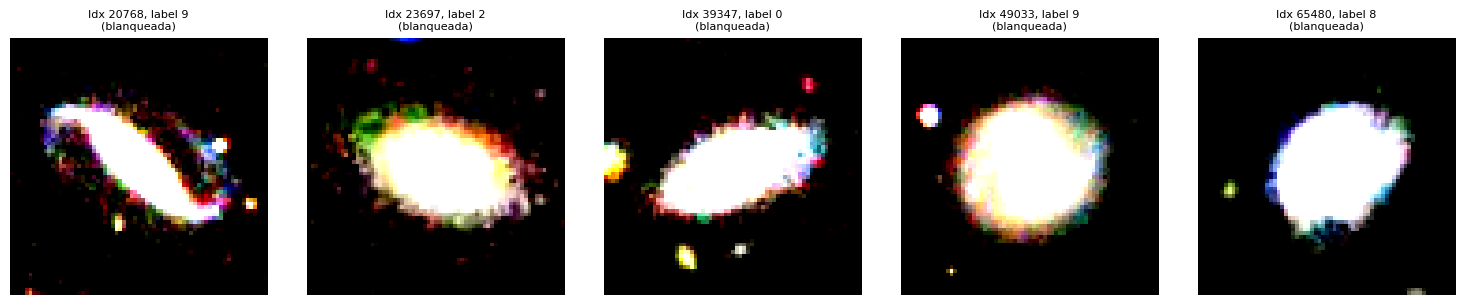

In [9]:
# -------------------------------------------------------------
# CELDA 4: Muestreo de las mismas imágenes DESPUÉS del blanqueo
# -------------------------------------------------------------
import h5py
import matplotlib.pyplot as plt

archivo_salida_whiten = 'galaxies_project3_rot_whiten.h5'

# Aquí usamos indices_muestra definido en la CELDA 2
with h5py.File(archivo_salida_whiten, 'r') as f:
    imgs_w = f['images']
    labs_w = f['ans']
    
    muestra_despues = [imgs_w[i][...] for i in indices_muestra]
    labels_muestra_w = [int(labs_w[i]) for i in indices_muestra]

n = len(muestra_despues)
plt.figure(figsize=(3*n, 3))
for i, (img, lab) in enumerate(zip(muestra_despues, labels_muestra_w)):
    ax = plt.subplot(1, n, i+1)
    if img.ndim == 2:
        ax.imshow(img, cmap='gray')
    else:
        # Al estar blanqueadas (valores ~N(0,1)), puede ayudar centrar la escala
        # pero matplotlib igual hace un mapeo automático:
        ax.imshow(img)
    ax.set_title(f"Idx {indices_muestra[i]}, label {lab}\n(blanqueada)", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


AQUI!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Shape de labels: (76983,)


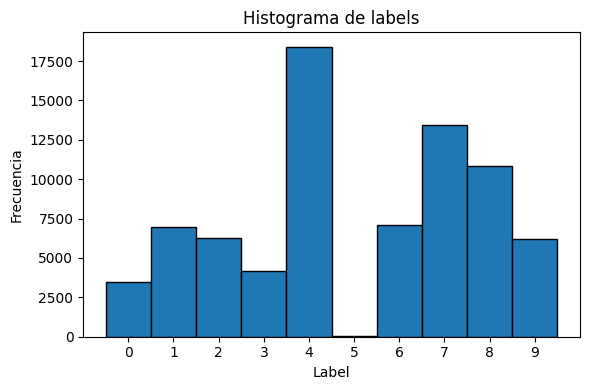

In [10]:
# Cargar labels desde el archivo (ajusta el nombre si es distinto)
with h5py.File('galaxies_project3_augmented.h5', 'r') as f:
    labels = f['ans'][()]   # <- aquí está tu vector de labels

print("Shape de labels:", labels.shape)

# Opción 1: Histograma directo (si los labels son enteros)
plt.figure(figsize=(6,4))
plt.hist(labels, bins=np.arange(labels.min(), labels.max() + 2) - 0.5, edgecolor='black')
plt.xlabel('Label')
plt.ylabel('Frecuencia')
plt.title('Histograma de labels')
plt.xticks(np.arange(labels.min(), labels.max() + 1))
plt.tight_layout()
plt.show()


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt
from torchvision import transforms

import h5py
import numpy as np
import os

In [3]:
# Configuración del Dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [4]:
# Clase Dataset para cargar el archivo .h5
class GalaxyH5Dataset(Dataset):
    def __init__(self, h5_path):
        self.h5_path = h5_path
        if not os.path.exists(h5_path):
            raise FileNotFoundError(f"No se encuentra el archivo: {h5_path}")

        with h5py.File(h5_path, 'r') as f:
            # Cargamos los datos a memoria
            self.images = f['images'][:]
            self.labels = f['ans'][:]

        self.num_classes = len(np.unique(self.labels))
        print(f"Dataset cargado. Imágenes: {self.images.shape}, Clases: {self.num_classes}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]      # (69, 69, 3)
        label = self.labels[idx]

        # Normalización [0, 1] y conversión a float32
        img = img.astype(np.float32) / 255.0

        # TRANSPOSICIÓN CLAVE: Keras usa (H,W,C), PyTorch usa (C,H,W)
        # Movemos el canal de la posición 2 a la 0.
        img = np.transpose(img, (2, 0, 1))

        return torch.from_numpy(img), torch.tensor(label, dtype=torch.long)

# Funciones

In [5]:
# Arquitectura AlexNet
class AlexNetGalaxy(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetGalaxy, self).__init__()

        self.features = nn.Sequential(
            # --- Bloque 1 ---
            # Keras: Conv2D(96, (11, 11), strides=(4, 4))
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            # Keras: MaxPooling2D((3, 3), strides=(2, 2))
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Keras: BatchNormalization()
            nn.BatchNorm2d(96),

            # --- Bloque 2 ---
            # Keras: Conv2D(256, (5, 5), padding='same')
            # En PyTorch, para kernel 5 mantener tamaño (padding='same'), usamos padding=2
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            # Keras: MaxPooling2D((3, 3), strides=(2, 2))
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Keras: BatchNormalization()
            nn.BatchNorm2d(256),

            # --- Bloque 3 ---
            # Keras: Conv2D(384, (3, 3), padding='same') -> padding=1 en Torch
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # --- Bloque 4 ---
            # Keras: Conv2D(384, (3, 3), padding='same')
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # --- Bloque 5 ---
            # Keras: Conv2D(256, (3, 3), padding='same')
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Keras: MaxPooling2D((3, 3), strides=(2, 2))
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Keras: BatchNormalization()
            nn.BatchNorm2d(256),
        )

        # --- Clasificador (Dense Layers) ---
        # Nota matemática:
        # Input: 69x69
        # Salida final de features: 256 canales x 1 x 1
        self.flatten_size = 256 * 1 * 1

        self.classifier = nn.Sequential(
            nn.Flatten(),

            # Keras: Dense(4096)
            nn.Linear(self.flatten_size, 4096),
            nn.ReLU(inplace=True),
            # Keras: Dropout(0.5)
            nn.Dropout(0.6),

            # Keras: Dense(4096)
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            # Keras: Dropout(0.5)
            nn.Dropout(0.6),

            # Keras: Dense(num_classes)
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    # Listas para guardar el historial
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        # --- Entrenamiento ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct_train / total_train

        # Guardar métricas de entrenamiento
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # --- Validación ---
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total

        # Guardar métricas de validación
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Época [{epoch+1}/{epochs}] "
              f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | "
              f"Train Acc: {epoch_train_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%")

    return history

# Transformacion de la data y Train

In [6]:
# Crear el Dataset y dividirlo
dataset = GalaxyH5Dataset('galaxies_project3_rot_whiten.h5')


# Pipeline para Entrenar (Con Data Augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),        # 1. Tamaño fijo
    transforms.RandomHorizontalFlip(),    # 2. Data Augmentation (flips)
    transforms.RandomRotation(10),        # 2. Data Augmentation (rotaciones)
    transforms.ToTensor(),                # 3. Convertir a Tensor (pone valores 0-1 automáticamente)
    transforms.Normalize(                 # 4. Estandarización (Valores típicos de ImageNet)
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Pipeline para VALIDACIÓN (Sin Augmentation, solo lo necesario)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(                 # Debes usar la misma normalización que en train
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_percent = 0.70
val_percent = 0.15
test_percent = 0.15

# Calcular longitudes absolutas
total_len = len(dataset)

longitud_train = int(total_len * train_percent)
longitud_val = int(total_len * val_percent)
longitud_test = total_len - longitud_train - longitud_val
train_set, val_set, test_set = random_split(dataset, [longitud_train, longitud_val, longitud_test])

# Crear los DataLoaders
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=256, shuffle=False)

# Instanciar el Modelo, Criterio y Optimizador
model = AlexNetGalaxy(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
# El optimizador necesita los parámetros del modelo para poder modificarlos
optimizer = optim.Adam(model.parameters(), lr=0.0008)

# Llamada para entrenar
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=100
)

Dataset cargado. Imágenes: (76983, 69, 69, 3), Clases: 10
Época [1/100] Train Loss: 0.9993 | Val Loss: 1.0201 | Train Acc: 62.98% | Val Acc: 64.52%
Época [2/100] Train Loss: 0.7084 | Val Loss: 0.8768 | Train Acc: 74.29% | Val Acc: 68.63%
Época [3/100] Train Loss: 0.6169 | Val Loss: 0.8604 | Train Acc: 77.62% | Val Acc: 69.78%
Época [4/100] Train Loss: 0.5730 | Val Loss: 0.7143 | Train Acc: 79.12% | Val Acc: 75.00%
Época [5/100] Train Loss: 0.5241 | Val Loss: 1.1484 | Train Acc: 80.90% | Val Acc: 64.60%
Época [6/100] Train Loss: 0.4795 | Val Loss: 0.8180 | Train Acc: 82.42% | Val Acc: 72.35%
Época [7/100] Train Loss: 0.4528 | Val Loss: 0.8176 | Train Acc: 83.31% | Val Acc: 67.88%
Época [8/100] Train Loss: 0.4165 | Val Loss: 0.6003 | Train Acc: 85.05% | Val Acc: 79.31%
Época [9/100] Train Loss: 0.3925 | Val Loss: 0.6265 | Train Acc: 85.58% | Val Acc: 79.02%
Época [10/100] Train Loss: 0.3704 | Val Loss: 0.6304 | Train Acc: 86.52% | Val Acc: 78.38%
Época [11/100] Train Loss: 0.3396 | Val L

# Resultados

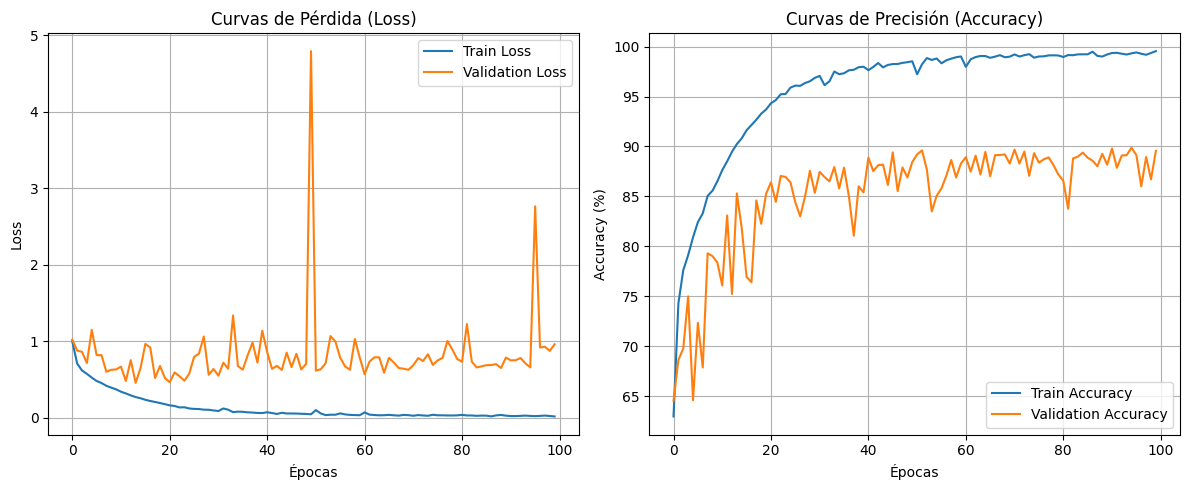

AttributeError: 'AlexNetGalaxy' object has no attribute 'predict'

In [8]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Gráfica de Pérdida (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Curvas de Pérdida (Loss)')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Gráfica de Precisión (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Curvas de Precisión (Accuracy)')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

plot_training_history(history)

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the training data
y_pred_probabilities = model.predict(test_normalized_images)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Get true labels (assuming one_hot_labels were used for training)
y_true_classes = np.argmax(test_one_hot_labels, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()